importing necessary libriaries

In [1]:
import tensorflow as tf

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
dataset,metadata = tfds.load('fashion_mnist',as_supervised= True,with_info = True)

In [5]:
train_dataset,test_dataset = dataset['train'],dataset['test']

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

Explore the Data

In [7]:
num_train_examples= metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of training examples =',num_train_examples)
print('Number of testing examples =',num_test_examples)


Number of training examples = 60000
Number of testing examples = 10000


Preprocess the data

In [8]:
def normalize(images,labels):
  images = tf.cast(images,tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

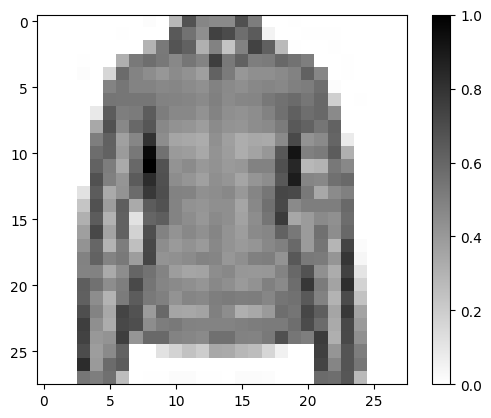

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(2):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image.

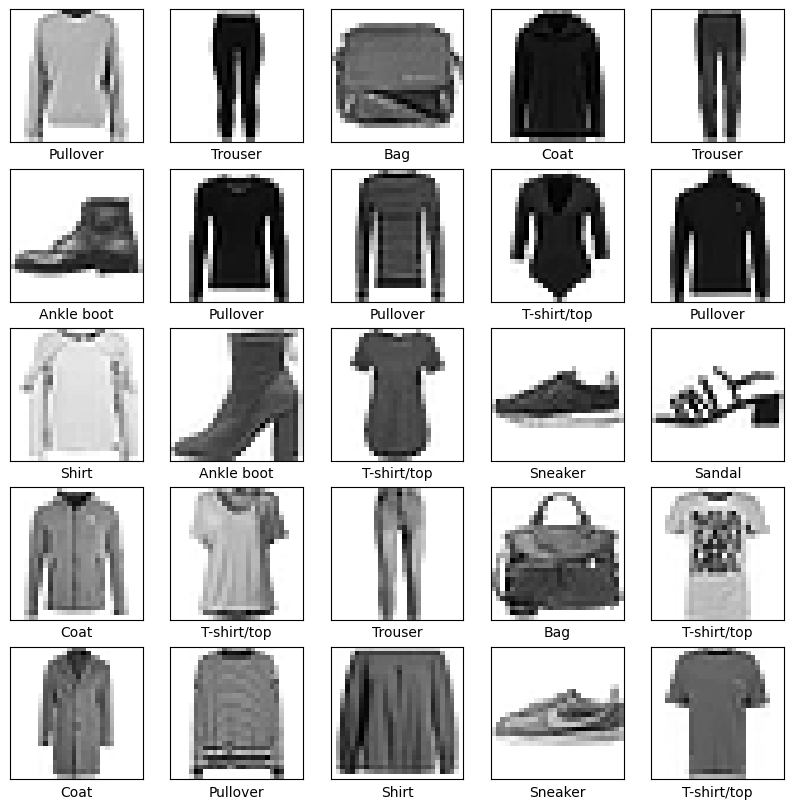

In [10]:
plt.figure(figsize = (10,10))
i = 0
for image, label in train_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])  # can be used to remove the xticks/pixel values
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image,cmap = plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

Build the model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding = 'same',activation = tf.nn.relu,input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),padding = 'same',activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2),strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation = tf.nn.relu),
    tf.keras.layers.Dense(10,activation = tf.nn.softmax)
])

Compile the model

In [12]:
model.compile(optimizer='adam',loss = tf.keras.losses.sparse_categorical_crossentropy,metrics = ['accuracy'])

Train the model

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset,epochs = 10,steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 27s 5ms/step - loss: 0.3989 - accuracy: 0.8569
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2606 - accuracy: 0.9067
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2141 - accuracy: 0.9218
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1818 - accuracy: 0.9329
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1570 - accuracy: 0.9416
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1352 - accuracy: 0.9502
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1158 - accuracy: 0.9567
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0989 - accuracy: 0.9631
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0854 - accuracy: 0.9690
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.07

Test the model

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)
print("Loss for test data",test_loss)

313/313 [==============================] - 2s 5ms/step - loss: 0.3442 - accuracy: 0.9126
Accuracy on test dataset: 0.9125999808311462
Loss for test data 0.34422728419303894


Make predictions and explore

In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 90ms/step


In [17]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([5.7915712e-09, 8.7617411e-07, 1.1246414e-02, 1.0263686e-08,
       3.8593921e-01, 4.4719978e-10, 6.0281205e-01, 2.0318561e-11,
       2.3254392e-09, 1.4140107e-06], dtype=float32)

In [19]:
np.argmax(predictions[0])

6

In [20]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

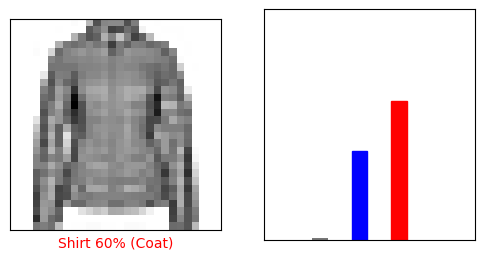

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

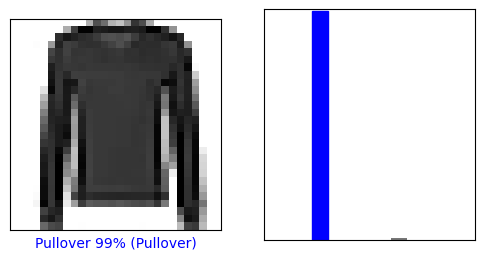

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

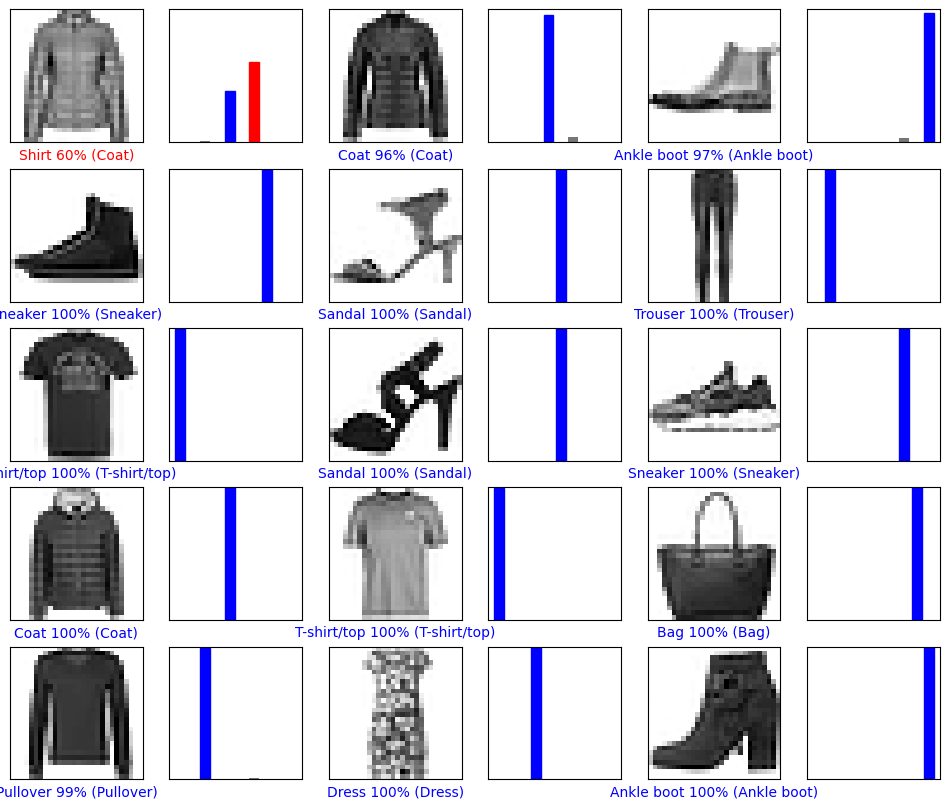

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image.

In [25]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [26]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image

In [27]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 125ms/step
[[5.7915681e-09 8.7617866e-07 1.1246410e-02 1.0263719e-08 3.8593951e-01
  4.4719950e-10 6.0281175e-01 2.0318589e-11 2.3254290e-09 1.4140098e-06]]


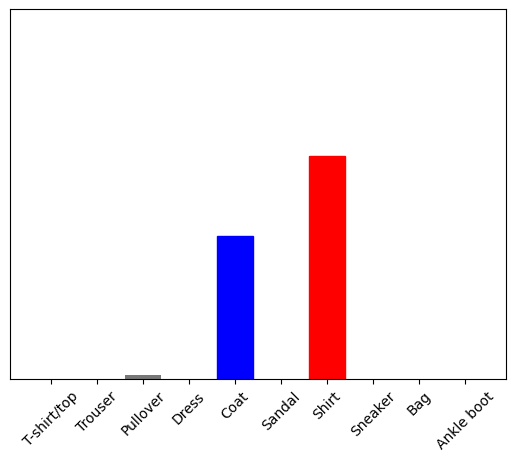

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [29]:
np.argmax(predictions_single[0])

6